# Salted Fish Classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# NOTE: `header=None`, I dun give a f*** bout what the data is
training_set = pd.read_csv('./salted_fish_train.csv', header=None).dropna()
test_set = pd.read_csv('./salted_fish_test.csv', header=None)

training_set.head()

,0,1,2,3,4,5,6,7,8
0,0.156,5,35.8,82.0,42.0,77.0,41.0,35,0
2,0.283,1,26.6,72.0,40.0,81.0,18.0,24,0
3,0.463,4,22.1,72.0,87.0,116.0,12.0,37,0
4,0.352,0,26.4,58.0,291.0,134.0,20.0,21,0
5,0.400,3,30.8,44.0,94.0,102.0,20.0,26,0


In [2]:
data_highests = training_set.iloc[:, :-1].max(0)
data_lowests = training_set.iloc[:, :-1].min(0)
# print(data_highests)
# print(data_lowests)

## Basic Helper Functions

In [3]:
def normalize(orig, ceil, floor):
    return (orig - floor) / (ceil - floor) - 0.5

# normalize(10, 100, 1)

In [4]:
def sigmoid(x):
    return (1. / (1. + np.exp(-x)))

# sigmoid(10.0)

In [5]:
def cross_entropy(x, y):
    x, y = np.array(x), np.array(y)
    return (y - 1) * np.log(1 - x) - y * np.log(x)

# cross_entropy(np.array([0.9, 0.1, 0.9, 0.1]), np.array([1, 1, 0, 0]))

In [6]:
def derivative_cross_entropy(x, y):
    x, y = np.array(x).reshape(1, -1), np.array(y).reshape(1, -1)
    return (y - 1) / (x - 1) - y / x

# derivative_cross_entropy(0.9, 1)

In [7]:
from random import randint

def approx_gauss_normalize(x, mean=0.0, sigma=1.0):
    return (sigmoid(x - mean) - 0.5) * sigma

# approx_gauss_normalize(randint(-100, 100) / 100, sigma=4.0)

In [8]:
def softmax(x):
    total_score = np.sum(x)
    return x / total_score

# softmax([1, 2, 3])

## Define Models

In [9]:
class LinearLayer:
    
    def __init__(self, in_node, out_node,
                 name=None,
                 random_init=True, dropout_rate=False,
                 learning_rate=1e-2):
        self._name = name or 'LinearLayer'
        self._weights = np.random.randn(in_node + 1, out_node) if random_init else np.zeros((in_node + 1, out_node))
        self._weights[-1] = 1 # bias term
        self._out = np.zeros((out_node, 1))
        self._dropout_rate = dropout_rate
        self._learning_rate = learning_rate
        self._next = None
        self._prev = None
    
    @property
    def shape(self):
        return self._weights.shape
    
    def forward(self, x):
        # `x` is array or row vector ==> (x1, x2, ...)
        #     or of shape (None, input_dimension)
        new_x = None
        if len(x.shape) == 1: # seires
            new_x = np.append(x, [1])
        else:                 # matrix
            new_x = np.concatenate(
                [x, np.ones((x.shape[0], 1))],
                axis=1
            )
        self._out = sigmoid(np.matmul(
            new_x, self._weights))
        return self._out
    
    def backword(self, y=None):
        new_y = y if y is not None else self._out
        new_y = np.sum(new_y.reshape(-1, 1), 0)
        # print(new_y)
        gradient = new_y
        self._weights -= gradient * self._learning_rate
        if self._prev:
            self._prev._out = gradient
        return self
    
    def __repr__(self):
        return '<{}: {:4d} =>{:4d}, lr={:.4f}>' \
            .format(self._name, self.shape[0], self.shape[1], self._learning_rate)

# linear = LinearLayer(7, 2, random_init=False) # 7 in, 2 out
# print(linear)
# print(linear.forward(np.random.randn(500, 7))) # batch size of 500
# grad = np.random.randn(1, 2); print(grad)
# print(linear.backword(grad)._weights)

In [10]:
class LinearLogisticClassifier:
    
    def __init__(self, features, classes, hidden, *args, **kwargs):
        # get model shape
        hidden.insert(0, features)
        hidden.append(classes)
        # insert first layer
        self._series = [ LinearLayer(hidden[0], hidden[1], *args, **kwargs) ]
        # insert more layers
        for hidden_size in hidden[2:]:
            self._series.append(
                LinearLayer(self._series[-1].shape[1], hidden_size, *args, **kwargs))
            self._series[-2]._next = self._series[-1]
            self._series[-1]._prev = self._series[-2]
        # check model definition
        for each in self._series: print(each)
            
    def forward(self, x):
        result = x
        for layer in self._series:
            result = layer.forward(result)
        return result
    
    def backword(self, label):
        self._series[-1]._out = derivative_cross_entropy(
            self._series[-1]._out, label
        )
        for layer in reversed(self._series):
            layer.backword()

    
    def predict(self, x):
        return softmax(self.forward(x))

# model = LinearLogisticClassifier(7, 2, [ ])
# model.forward(np.random.randn(7))
# model.backword(np.random.randn(2))
# model.predict(np.random.randn(7))

## Proof of Model Convergence

<LinearLayer:    9 =>  10, lr=0.0010>
<LinearLayer:   11 =>   1, lr=0.0010>


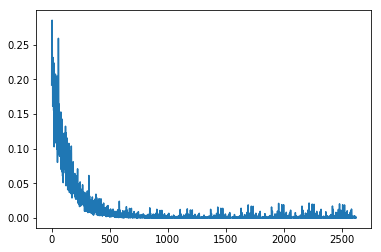

In [11]:
model = LinearLogisticClassifier(8, 1, [ 10 ], learning_rate=1e-3, random_init=True)

errors = []

for iteration in range(10):
    for each in training_set.itertuples():
        data = normalize(each[1:-1], data_highests, data_lowests)
        # label = np.zeros(2); label[each[-1]] = 1
        label = 1 if each[-1] else 1
        # print(data, '==>', label)
        if (each[0] * iteration) % 20 == 0:
            # print('{}-th iteration'.format(each[0] + 1))
            pass
        hypothesis = model.forward(data)
        # print(hypothesis)
        errors.append(np.sum(cross_entropy(hypothesis, label)))
        model.backword(label)
    
# print(errors)
plt.plot(errors)
plt.show()

## Start Learning

<LinearLayer:    9 =>  20, lr=0.0000>
<LinearLayer:   21 =>  20, lr=0.0000>
<LinearLayer:   21 =>  20, lr=0.0000>
<LinearLayer:   21 =>  20, lr=0.0000>
<LinearLayer:   21 =>  20, lr=0.0000>
<LinearLayer:   21 =>  20, lr=0.0000>
<LinearLayer:   21 =>  20, lr=0.0000>
<LinearLayer:   21 =>  20, lr=0.0000>
<LinearLayer:   21 =>  20, lr=0.0000>
<LinearLayer:   21 =>  20, lr=0.0000>
<LinearLayer:   21 =>  20, lr=0.0000>
<LinearLayer:   21 =>  20, lr=0.0000>
<LinearLayer:   21 =>  20, lr=0.0000>
<LinearLayer:   21 =>  20, lr=0.0000>
<LinearLayer:   21 =>  20, lr=0.0000>
<LinearLayer:   21 =>  20, lr=0.0000>
<LinearLayer:   21 =>  20, lr=0.0000>
<LinearLayer:   21 =>  20, lr=0.0000>
<LinearLayer:   21 =>  20, lr=0.0000>
<LinearLayer:   21 =>  20, lr=0.0000>
<LinearLayer:   21 =>   1, lr=0.0000>


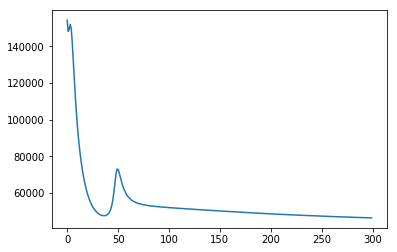


Pretty smooth convergence. But error values are still high...

The scikit-learn example in `./salted_fish_sklearn.ipynb` shows
that regularization plays vital rule!



In [12]:
model = LinearLogisticClassifier(8, 1, [ 20 for _ in range(20)], learning_rate=1e-5, random_init=True)

errors = []

for iteration in range(300):
    datas = normalize(training_set.iloc[:, :-1], data_highests, data_lowests)
    labels = training_set.iloc[:, -1]
    hypothesis = model.forward(datas) # NOTE: All data in **ONE BATCH!**
                                      #       Utilizing all matrix accelerations.
    errors.append(np.sum(cross_entropy(hypothesis, labels)))
    model.backword(labels)
    
plt.plot(errors)
plt.show()

print('''
Pretty smooth convergence. But error values are still high...

The scikit-learn example in `./salted_fish_sklearn.ipynb` shows
that regularization plays vital rule!
''')

## Moment of Truth!

In [13]:
clean_test_set = test_set.dropna()
test_feature, test_label = clean_test_set.iloc[:, :-1], clean_test_set.iloc[:, -1]

prediction = model.forward(test_feature)
prediction = (prediction > 0.5).flatten()

accuracy = np.sum(prediction == test_label) / prediction.shape[0]
print('accuracy on test set: {:.4f}'.format(accuracy * 100))

print('''
Sometimes, when th emit would yield an accuracy of approx. 35%,
the same result you'll get with scikit-learn's `LogisticRegression`,
if you leave all hyper-parameters as default.
''')

accuracy on test set: 64.6154

Sometimes, it would yield an accuracy of approx. 35%,
the same result you'll get with scikit-learn's `LogisticRegression`,
if you leave all hyper-parameters as default.



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [14]:
if all(prediction):
    print('''
This would very likely to happen if you get accuracy of 35%,
when the model would actually learn nothing and decided
that everyone is *salted fish* :-)
''')